In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 2. Single particle tracking



## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

import datasets
datasets.load('ParticleTracking')

IMAGE_SIZE = 51

ParticleTracking already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 51 by 51 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 1 micron and 2 microns, and a refractive index between 1.5 and 1.6. Its position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = dt.MieParticle(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2)  + (np.random.rand(2) - 0.5) * 6,
    z=lambda: np.random.randn() * 5,
    radius=lambda:1e-6 + np.random.rand() * 1e-6 ,
    refractive_index=lambda: np.random.rand() * 0.1 + 1.5,
    position_unit="pixel",
    L=10
)


The particle is imaged using a brightfield microscope with NA between 0.15 and 0.2 and a illuminating laser wavelength between 400 and 700 nm. To simulate the broad spectrum we define 10 individual optical devices, each imaging the particle at a single wavelength. The result is then averaged.

In [4]:

spectrum = np.linspace(400e-9, 700e-9, 10)

imaged_particle_list = []

for wavelength in spectrum:
    single_wavelength_optics = dt.Brightfield(
        NA=lambda magnification: 0.15 + np.random.rand() * 0.05,
        resolution=0.2e-6 + np.random.rand() * 0.2e-6,
        magnification=1.5,
        wavelength=wavelength,
        padding=(32, 32, 32, 32),
        output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    )
    
    imaged_particle_list.append(
        single_wavelength_optics(particle)
    )

dataset = dt.Average(imaged_particle_list)

### 2.2 Defining the training label

The training label is extracted directly from the image as the `position` property divided by the image size, such that the posible values are contained within -0.5 and 0.5.

In [5]:
def get_label(image):
    px = np.array(image.get_property("position")) / IMAGE_SIZE - 0.5
    return px

### 2.3 Visualizing the dataset

We resolve and show 16 images, with a green circle indicating the particle position.

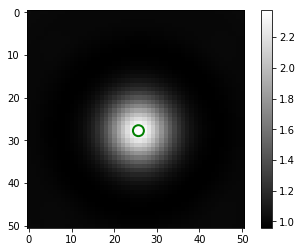

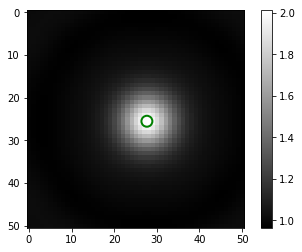

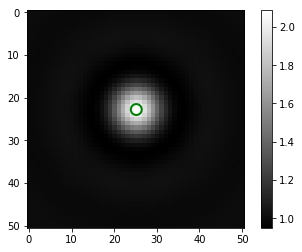

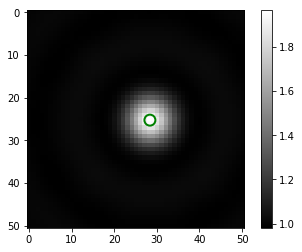

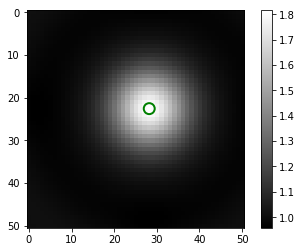

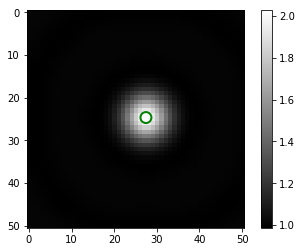

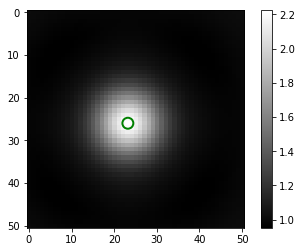

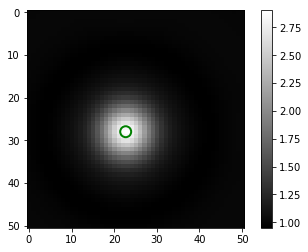

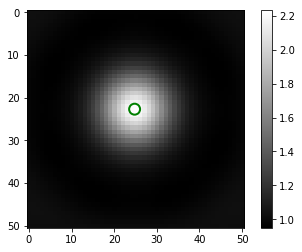

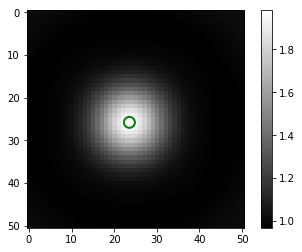

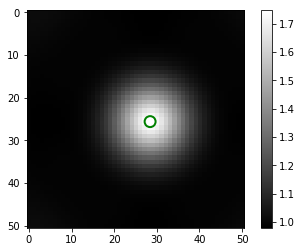

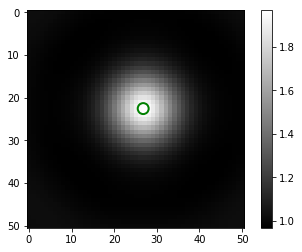

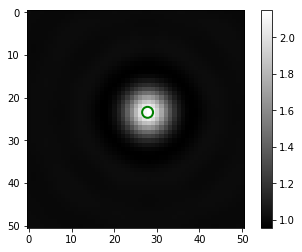

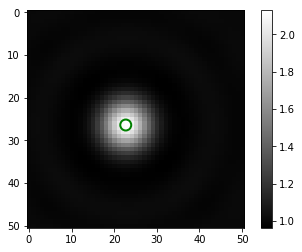

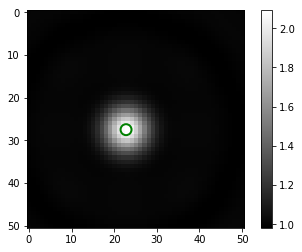

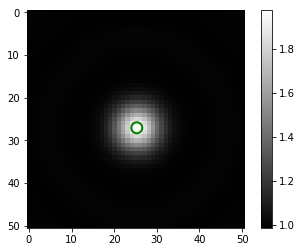

In [6]:
NUMBER_OF_IMAGES = 16

for _ in range(NUMBER_OF_IMAGES):

    dataset.update()
    image_of_particle = dataset.resolve()
    position_of_particle = get_label(image_of_particle) * IMAGE_SIZE + IMAGE_SIZE / 2
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.colorbar()
    plt.scatter(position_of_particle[1], position_of_particle[0], s=120, facecolors='none', edgecolors="g", linewidth=2)
    plt.show()
    

### 2.4 Augmenting dataset

Simulating mie particles is slow. To speed up training we implement augmentation techniques. Here we flip and mirror the image. Note that DeepTrack ensures that the position is still correct after the augmentation. 

In [7]:
augmented_dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))

We add noises after augmentation. This allows the augmented images to be more distinct.

In [8]:
gradient = dt.IlluminationGradient(
    gradient=lambda: -2e-3 + np.random.rand(2) * 4e-3,
)

noise = dt.Poisson(
    min_snr=5,
    max_snr=100,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr - min_snr),
    background=1
)

normalization = dt.NormalizeMinMax(0, 1)

augmented_dataset += gradient + noise + normalization 


## 3. Defining the network

The network used is a Convolutional network, with mse as loss.

In [9]:
import keras.backend as K
import keras.optimizers as optimizers
def pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1))) * IMAGE_SIZE

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16, 32, 64),
    dense_layers_dimensions=(32, 32),
    steps_per_pooling=1,
    number_of_outputs=2,
    loss="mse",
    metrics=[pixel_error],
    optimizer="adam"
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 51, 51, 16)        160       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

## 4. Training the network

We use the `ContinuousGenerator` to generate the images. It creates a new therad and generates images while the model is training. 

Set TRAIN_MODEL to True to train the model, otherwise a pretrained model is downloaded.

In [10]:
TRAIN_MODEL = False

from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 200

validation_set = [augmented_dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        augmented_dataset,
        get_label,
        min_data_size=int(1e4),
        max_data_size=int(2e4),
        batch_size=64
    )

    histories = []

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            callbacks=[
                EarlyStopping(patience=20, restore_best_weights=True)
            ],
            epochs=250
        )

    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["loss", "val_loss"])
    plt.yscale('log')
    plt.show()
    
else:
    model_path = datasets.load_model("ParticleTracking")
    model.load_weights(model_path)

ParticleTracking already downloaded! Use force_overwrite=True to redownload the model.


## 5. Evaluating the network

### 5.1 Prediction vs actual

We show a few images, with the true position as a green circle, and the predicted position as a blue cross.

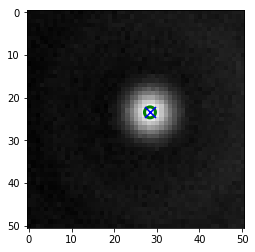

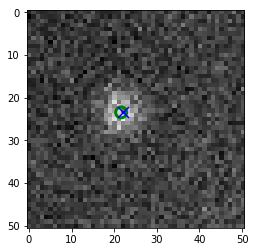

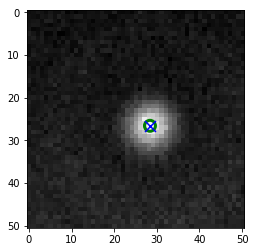

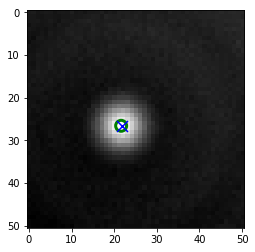

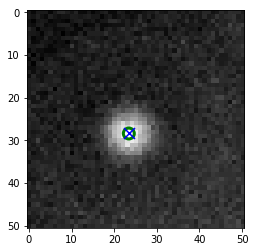

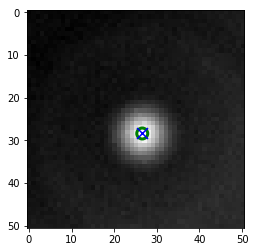

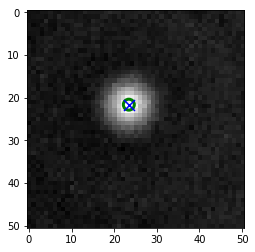

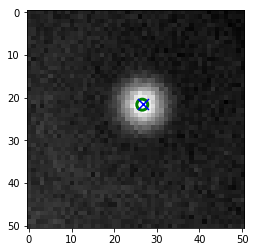

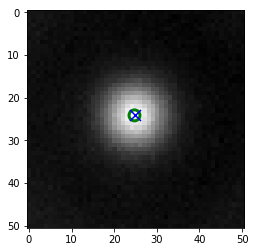

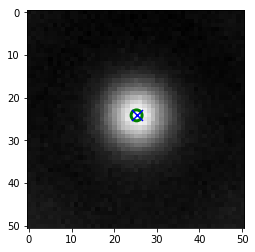

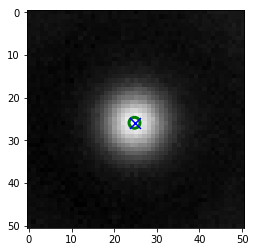

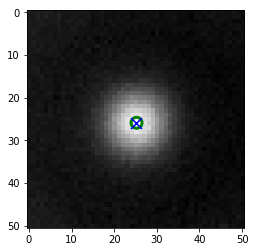

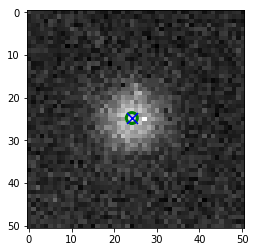

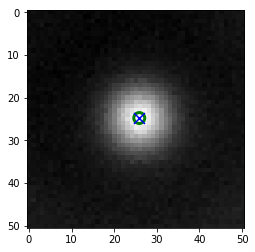

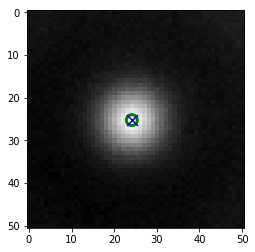

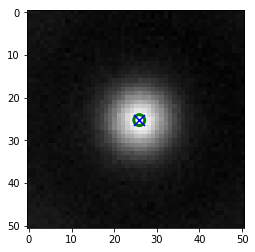

In [11]:
NUMBER_OF_IMAGES = 16

for _ in range(NUMBER_OF_IMAGES):
    augmented_dataset.update()
    image_of_particle = augmented_dataset.resolve(skip_augmentations=True)
    position_of_particle = get_label(image_of_particle) * IMAGE_SIZE + IMAGE_SIZE / 2
    prediction = model.predict(np.array([image_of_particle])) * IMAGE_SIZE + IMAGE_SIZE / 2
    
    plt.imshow(image_of_particle[:, :, 0], cmap="gray")
    plt.scatter(position_of_particle[1], position_of_particle[0], marker='o', s=120, facecolors='none', edgecolors="g", linewidth=3)
    plt.scatter(prediction[0, 1], prediction[0, 0], marker='x', s=120, c="b")
    plt.show()

### 5.2 Prediction vs actual

We show the prediction of each output versus the ground truth

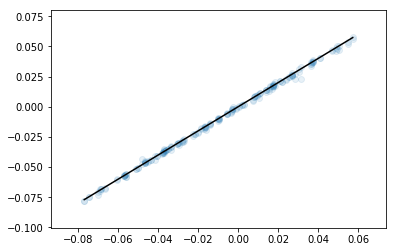

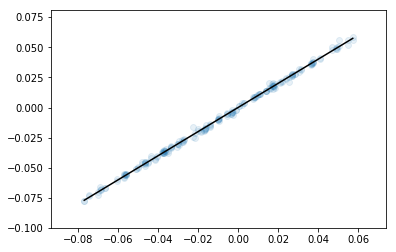

In [12]:
validation_prediction = model.predict(np.array(validation_set))
labels = np.array(validation_labels)
for col in range(validation_prediction.shape[-1]):
    label_col = labels[:, col]
    prediction_col = validation_prediction[:, col]
    plt.scatter(label_col, prediction_col, alpha=0.1)
    
    plt.plot([np.min(label_col), np.max(label_col)], 
             [np.min(label_col), np.max(label_col)], c='k')
    plt.show()

### 5.3 Prediction vs property value

We show the the pixel error as a function of some properties.

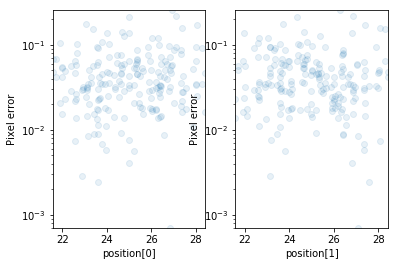

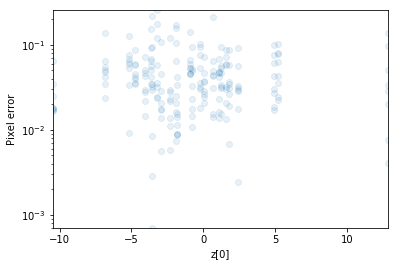

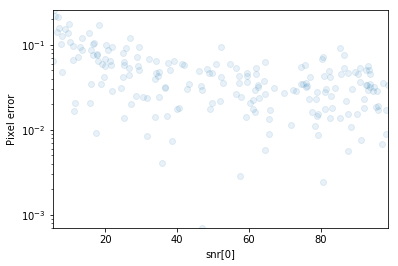

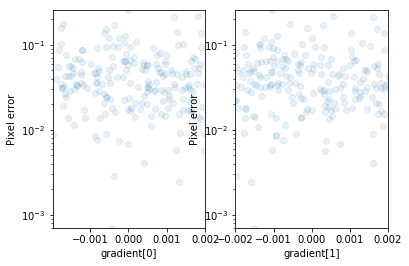

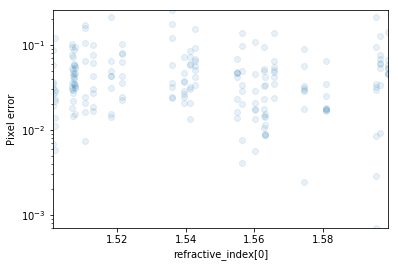

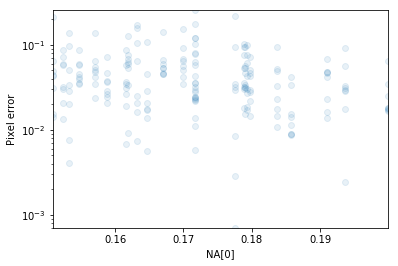

In [13]:
properties = ["position", "z", "snr", "gradient", "refractive_index", "NA"]

validation_prediction = model.predict(np.array(validation_set))

snr = [image.get_property("snr") for image in validation_set]

validation_error = np.mean(np.abs(validation_prediction - validation_labels), axis=-1) * 51

for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
    
    for col in range(property_values.shape[1]):
        values = property_values[:, col]

        plt.subplot(1, property_values.shape[1], col + 1)

        plt.scatter(values, validation_error, alpha=0.1)
        plt.xlim([np.min(values), np.max(values)])
        plt.ylim([np.min(validation_error), np.max(validation_error)])
        plt.yscale("log")
        plt.ylabel("Pixel error")
        plt.xlabel("{0}[{1}]".format(property_name, col))

    
    plt.show()

### 5.3 Experimental data
We play some experimental videos tracked by the DeepTrack model

In [14]:
import cv2
import IPython

def track_video(video):
    video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize variables
    frames = np.zeros((100, video_height, video_width))

    predicted_positions = np.zeros((100, 2))
    rpi = np.zeros((100, 2))

    # Track the positions of the particles frame by frame
    for i in range(100):

        # Read the current frame from the video
        (ret, frame) = video.read()

        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

        # Convert color image to grayscale.
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255

        ### Resize the frame
        frame_resize = cv2.resize(frame, (51, 51))

        predicted_position = model.predict(np.reshape(frame_resize, (1, 51, 51, 1)))

        predicted_position_x = predicted_position[0,0] *  video_width + video_width / 2
        predicted_position_y = predicted_position[0,1] *  video_height + video_height / 2

        IPython.display.clear_output(wait=True)

        plt.imshow(frame, cmap="gray")
        plt.scatter(predicted_position_y, predicted_position_x, marker='x', s=120, c="b")

        plt.show()


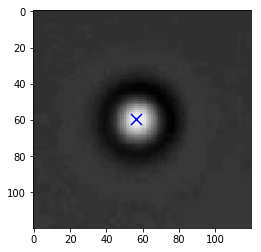

In [15]:
video = cv2.VideoCapture("./datasets/ParticleTracking/DeepTrack - Example 2 - Optically Trapped Particle good.mp4")
track_video(video)

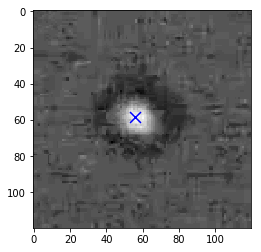

In [16]:
video = cv2.VideoCapture("./datasets/ParticleTracking/DeepTrack - Example 2 - Optically Trapped Particle bad.mp4")
track_video(video)